In [19]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)

In [20]:
df = pd.read_csv("final_dataset_clean.csv")
df.head()

,Text,Label
0,perpanjang stnk kendaraan,Needs
1,beli air darurat,Needs
2,beli beras merah,Needs
3,beli deterjen pakaian,Needs
4,beli map dokumen,Needs


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7013 entries, 0 to 7012
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    7013 non-null   object
 1   Label   7013 non-null   object
dtypes: object(2)
memory usage: 109.7+ KB


In [22]:
df.isna().sum()

Text     0
Label    0
dtype: int64

In [23]:
df["Label"].value_counts()

Label
Needs      1412
Invest     1411
Wants      1402
Savings    1395
Debts      1393
Name: count, dtype: int64

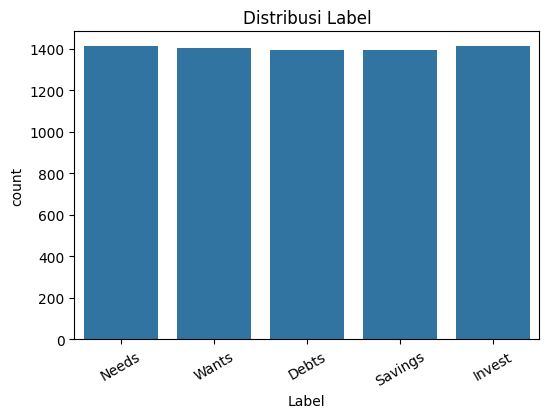

In [24]:
plt.figure(figsize=(6,4))
sns.countplot(x="Label", data=df)
plt.xticks(rotation=30)
plt.title("Distribusi Label")
plt.show()

In [25]:
df["text_length"] = df["Text"].apply(lambda x: len(x.split()))
df["text_length"].describe()

count    7013.000000
mean        4.924996
std         2.091890
min         2.000000
25%         3.000000
50%         4.000000
75%         6.000000
max        12.000000
Name: text_length, dtype: float64

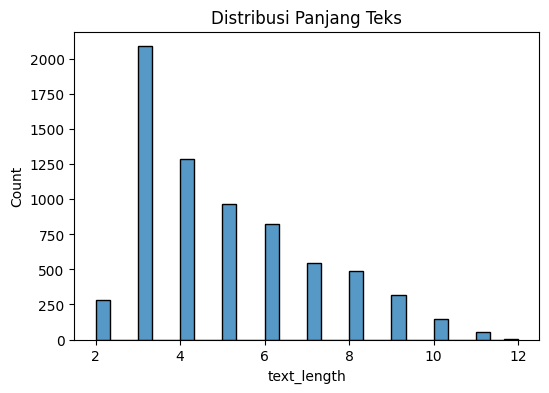

In [26]:
plt.figure(figsize=(6,4))
sns.histplot(df["text_length"], bins=30)
plt.title("Distribusi Panjang Teks")
plt.show()

# Encoding & Training Model

In [27]:
le = LabelEncoder()
df["label_encoded"] = le.fit_transform(df["Label"])

le.classes_

array(['Debts', 'Invest', 'Needs', 'Savings', 'Wants'], dtype=object)

In [28]:
import joblib
joblib.dump(le, "label_encoder.pkl")

['label_encoder.pkl']

In [29]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["Text"].tolist(),
    df["label_encoded"].tolist(),
    test_size=0.3,
    stratify=df["label_encoded"],
    random_state=42
)

In [30]:
tokenizer = AutoTokenizer.from_pretrained(
    "indobenchmark/indobert-base-p1"
)

In [31]:
train_encodings = tokenizer(
    train_texts,
    truncation=True,
    padding=True,
    max_length=64
)

val_encodings = tokenizer(
    val_texts,
    truncation=True,
    padding=True,
    max_length=64
)

In [32]:
class BudgetDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

In [33]:
train_dataset = BudgetDataset(train_encodings, train_labels)
val_dataset = BudgetDataset(val_encodings, val_labels)

In [34]:
model = AutoModelForSequenceClassification.from_pretrained(
    "indobenchmark/indobert-base-p1",
    num_labels=len(le.classes_)
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [35]:
training_args = TrainingArguments(
    output_dir="./indobert-dataset",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss"
)   

In [36]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer
)

C:\Users\dwiok\AppData\Local\Temp\ipykernel_7180\3286434519.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [37]:
trainer.train()

C:\Users\dwiok\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss
1,0.044000,0.037506
2,0.013700,0.033936
3,0.009200,0.028850
4,0.002100,0.028672
5,0.002000,0.028411


C:\Users\dwiok\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\dwiok\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\dwiok\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\dwiok\AppData\Local\Packages

TrainOutput(global_step=1535, training_loss=0.037816580339465354, metrics={'train_runtime': 4929.8102, 'train_samples_per_second': 4.979, 'train_steps_per_second': 0.311, 'total_flos': 189206097854850.0, 'train_loss': 0.037816580339465354, 'epoch': 5.0})

In [38]:
trainer.save_model("./indobert-dataset-final")
tokenizer.save_pretrained("./indobert-dataset-final")

('./indobert-dataset-final\\tokenizer_config.json',
 './indobert-dataset-final\\special_tokens_map.json',
 './indobert-dataset-final\\vocab.txt',
 './indobert-dataset-final\\added_tokens.json',
 './indobert-dataset-final\\tokenizer.json')

In [39]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import joblib
import torch

tokenizer = AutoTokenizer.from_pretrained("./indobert-dataset-final")
model = AutoModelForSequenceClassification.from_pretrained(
    "./indobert-dataset-final"
)
model.eval()

le = joblib.load("label_encoder.pkl")

In [40]:
def predict_base(text):
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=64
    )

    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=1)
        pred_id = torch.argmax(probs).item()
        confidence = probs.max().item()

    label = le.inverse_transform([pred_id])[0]
    return label, confidence, text


In [41]:
preds = trainer.predict(val_dataset)
y_pred = np.argmax(preds.predictions, axis=1)

print(classification_report(val_labels, y_pred, target_names=le.classes_))

C:\Users\dwiok\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


              precision    recall  f1-score   support

       Debts       1.00      1.00      1.00       418
      Invest       1.00      1.00      1.00       423
       Needs       0.99      0.99      0.99       424
     Savings       0.99      1.00      1.00       418
       Wants       0.99      0.99      0.99       421

    accuracy                           0.99      2104
   macro avg       0.99      0.99      0.99      2104
weighted avg       0.99      0.99      0.99      2104



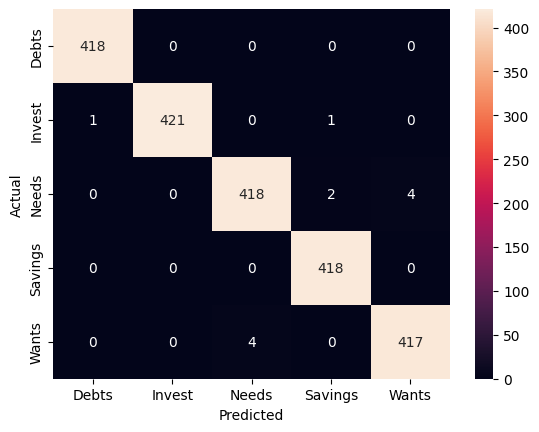

In [42]:
cm = confusion_matrix(val_labels, y_pred)   

sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [55]:
predict_base("ke warung beli rokok")

('Needs', 0.9952418804168701, 'ke warung beli rokok')